In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


=== Fourier Attention ===
Forward pass time: 0.004583 seconds
Output shape: torch.Size([8, 512, 64])
Parameter count: 8,320


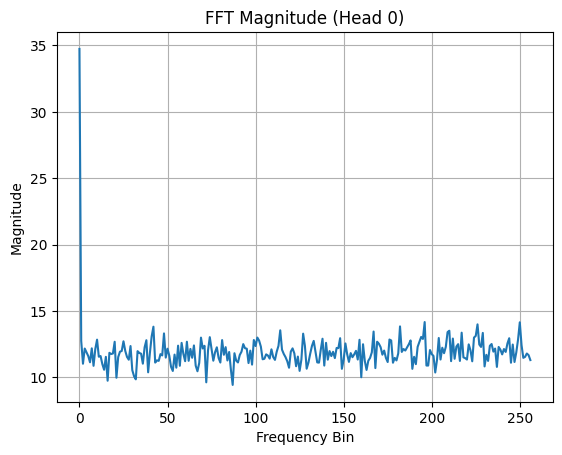


=== Standard Self-Attention ===
Forward pass time: 0.143939 seconds
Output shape: torch.Size([8, 512, 64])
Parameter count: 16,640


In [4]:
import torch
import torch.nn as nn
from einops import rearrange
import time
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Fourier Attention
class FourierAttention(nn.Module):
    def __init__(self, dim, num_heads=8):
        super(FourierAttention, self).__init__()
        assert dim % num_heads == 0, "dim must be divisible by num_heads"
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.input_proj = nn.Linear(dim, dim)
        self.output_proj = nn.Linear(dim, dim)

    def forward(self, x):
        B, N, D = x.shape
        x_proj = self.input_proj(x)
        x_heads = rearrange(x_proj, "b n (h d) -> b h n d", h=self.num_heads)
        x_fft = torch.fft.rfft(x_heads, dim=2)
        x_ifft = torch.fft.irfft(x_fft, n=N, dim=2)
        x_out = rearrange(x_ifft, "b h n d -> b n (h d)")
        out = self.output_proj(x_out)
        return out


# Standard Self-Attention
class StandardSelfAttention(nn.Module):
    def __init__(self, dim, num_heads=8):
        super(StandardSelfAttention, self).__init__()
        assert dim % num_heads == 0
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.query_proj = nn.Linear(dim, dim)
        self.key_proj = nn.Linear(dim, dim)
        self.value_proj = nn.Linear(dim, dim)
        self.output_proj = nn.Linear(dim, dim)

    def forward(self, x):
        B, N, D = x.shape
        query = self.query_proj(x)
        key = self.key_proj(x)
        value = self.value_proj(x)

        query = rearrange(query, 'b n (h d) -> b h n d', h=self.num_heads)
        key = rearrange(key, 'b n (h d) -> b h n d', h=self.num_heads)
        value = rearrange(value, 'b n (h d) -> b h n d', h=self.num_heads)

        attn_scores = torch.einsum('bhid,bhjd->bhij', query, key) / self.head_dim ** 0.5
        attn_weights = attn_scores.softmax(dim=-1)
        attended = torch.einsum('bhij,bhjd->bhid', attn_weights, value)
        attended = rearrange(attended, 'b h n d -> b n (h d)')
        out = self.output_proj(attended)
        return out


# Benchmarking Function
def benchmark(model, x, label, visualize_fft=False):
    model.to(device)
    x = x.to(device)
    model.eval()

    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()
        torch.cuda.synchronize()

    start_time = time.time()
    with torch.no_grad():
        out = model(x)
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    end_time = time.time()

    print(f"\n=== {label} ===")
    print(f"Forward pass time: {end_time - start_time:.6f} seconds")
    print(f"Output shape: {out.shape}")
    print(f"Parameter count: {sum(p.numel() for p in model.parameters()):,}")
    if torch.cuda.is_available():
        mem = torch.cuda.max_memory_allocated(device) / (1024 ** 2)
        print(f"Peak memory usage: {mem:.2f} MB")

    # Optional: visualize FFT magnitude for one head
    if visualize_fft and isinstance(model, FourierAttention):
        with torch.no_grad():
            x_proj = model.input_proj(x)
            x_heads = rearrange(x_proj, "b n (h d) -> b h n d", h=model.num_heads)
            fft = torch.fft.rfft(x_heads, dim=2)
            magnitude = fft.abs().mean(dim=(0, 3)).cpu()  # mean over batch and dim
            plt.plot(magnitude[0].numpy())
            plt.title("FFT Magnitude (Head 0)")
            plt.xlabel("Frequency Bin")
            plt.ylabel("Magnitude")
            plt.grid(True)
            plt.show()


# Run All Tests
if __name__ == "__main__":
    batch_size = 8
    seq_len = 512  # ← Change to 128 or 1024 as needed
    dim = 64
    num_heads = 8

    x = torch.randn(batch_size, seq_len, dim)

    benchmark(FourierAttention(dim, num_heads), x, "Fourier Attention", visualize_fft=True)
    benchmark(StandardSelfAttention(dim, num_heads), x, "Standard Self-Attention")



=== Fourier Attention ===
Forward pass time: 2.969358 seconds
Output shape: torch.Size([8, 512, 64])
Parameter count: 8,320


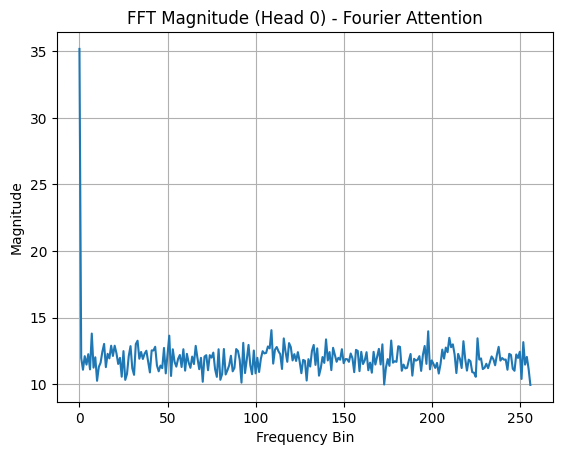


=== Fourier Attention with Gating ===
Forward pass time: 0.015812 seconds
Output shape: torch.Size([8, 512, 64])
Parameter count: 8,384


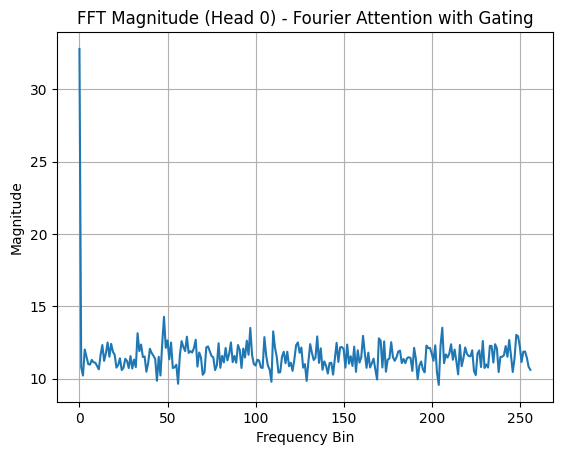


=== Standard Self-Attention ===
Forward pass time: 0.232351 seconds
Output shape: torch.Size([8, 512, 64])
Parameter count: 16,640


In [3]:
import torch
import torch.nn as nn
from einops import rearrange
import time
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# ========== Positional Encoding ==========
class PositionalEncoding(nn.Module):
    def __init__(self, dim, max_len=2048):
        super().__init__()
        pe = torch.zeros(max_len, dim)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, dim, 2) * (-torch.log(torch.tensor(10000.0)) / dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe)

    def forward(self, x):
        return x + self.pe[:x.size(1)]


# ========== Fourier Attention ==========
class FourierAttention(nn.Module):
    def __init__(self, dim, num_heads=8):
        super().__init__()
        assert dim % num_heads == 0
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.input_proj = nn.Linear(dim, dim)
        self.output_proj = nn.Linear(dim, dim)

    def forward(self, x):
        B, N, D = x.shape
        x_proj = self.input_proj(x)
        x_heads = rearrange(x_proj, "b n (h d) -> b h n d", h=self.num_heads)
        x_fft = torch.fft.rfft(x_heads, dim=2)
        x_ifft = torch.fft.irfft(x_fft, n=N, dim=2)
        x_out = rearrange(x_ifft, "b h n d -> b n (h d)")
        return self.output_proj(x_out)


# ========== Fourier Attention with Gating ==========
class FourierAttentionWithGating(nn.Module):
    def __init__(self, dim, num_heads=8):
        super().__init__()
        assert dim % num_heads == 0
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.input_proj = nn.Linear(dim, dim)
        self.output_proj = nn.Linear(dim, dim)

        # Learnable frequency gates (applied to FFT domain)
        self.freq_weight = nn.Parameter(torch.ones(num_heads, self.head_dim))

    def forward(self, x):
        B, N, D = x.shape
        x_proj = self.input_proj(x)
        x_heads = rearrange(x_proj, "b n (h d) -> b h n d", h=self.num_heads)
        x_fft = torch.fft.rfft(x_heads, dim=2)
        x_fft = x_fft * self.freq_weight[:, None, :]  # Broadcast across batch
        x_ifft = torch.fft.irfft(x_fft, n=N, dim=2)
        x_out = rearrange(x_ifft, "b h n d -> b n (h d)")
        return self.output_proj(x_out)


# ========== Standard Self-Attention ==========
class StandardSelfAttention(nn.Module):
    def __init__(self, dim, num_heads=8):
        super().__init__()
        assert dim % num_heads == 0
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.query_proj = nn.Linear(dim, dim)
        self.key_proj = nn.Linear(dim, dim)
        self.value_proj = nn.Linear(dim, dim)
        self.output_proj = nn.Linear(dim, dim)

    def forward(self, x):
        B, N, D = x.shape
        query = rearrange(self.query_proj(x), "b n (h d) -> b h n d", h=self.num_heads)
        key = rearrange(self.key_proj(x), "b n (h d) -> b h n d", h=self.num_heads)
        value = rearrange(self.value_proj(x), "b n (h d) -> b h n d", h=self.num_heads)

        scores = torch.einsum("bhid,bhjd->bhij", query, key) / self.head_dim**0.5
        weights = scores.softmax(dim=-1)
        attended = torch.einsum("bhij,bhjd->bhid", weights, value)
        attended = rearrange(attended, "b h n d -> b n (h d)")
        return self.output_proj(attended)


# ========== Benchmark Function ==========
def benchmark(model, x, label, visualize_fft=False):
    model.to(device)
    x = x.to(device)
    model.eval()

    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()
        torch.cuda.synchronize()

    start_time = time.time()
    with torch.no_grad():
        out = model(x)
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    end_time = time.time()

    print(f"\n=== {label} ===")
    print(f"Forward pass time: {end_time - start_time:.6f} seconds")
    print(f"Output shape: {out.shape}")
    print(f"Parameter count: {sum(p.numel() for p in model.parameters()):,}")
    if torch.cuda.is_available():
        mem = torch.cuda.max_memory_allocated(device) / (1024 ** 2)
        print(f"Peak memory usage: {mem:.2f} MB")

    # Optional FFT Visualization
    if visualize_fft and isinstance(model, (FourierAttention, FourierAttentionWithGating)):
        with torch.no_grad():
            x_proj = model.input_proj(x)
            x_heads = rearrange(x_proj, "b n (h d) -> b h n d", h=model.num_heads)
            fft = torch.fft.rfft(x_heads, dim=2)
            magnitude = fft.abs().mean(dim=(0, 3)).cpu()
            plt.plot(magnitude[0].numpy())
            plt.title(f"FFT Magnitude (Head 0) - {label}")
            plt.xlabel("Frequency Bin")
            plt.ylabel("Magnitude")
            plt.grid(True)
            plt.show()


# ========== Run Tests ==========
if __name__ == "__main__":
    batch_size = 8
    seq_len = 512
    dim = 64
    num_heads = 8

    x = torch.randn(batch_size, seq_len, dim)

    benchmark(FourierAttention(dim, num_heads), x, "Fourier Attention", visualize_fft=True)
    benchmark(FourierAttentionWithGating(dim, num_heads), x, "Fourier Attention with Gating", visualize_fft=True)
    benchmark(StandardSelfAttention(dim, num_heads), x, "Standard Self-Attention")


⚠️ torch.compile() is not supported on this GPU, using uncompiled models.
Fourier Attention took 0.1277 seconds


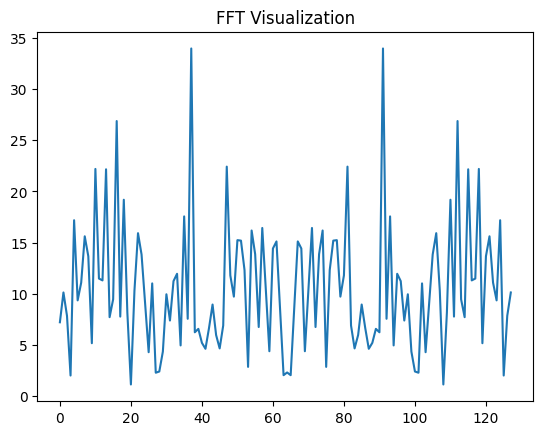

Standard Attention took 0.0041 seconds


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time

# Check if torch.compile is supported (CUDA >= 7.0)
def is_compile_supported():
    if torch.cuda.is_available():
        cap_major, cap_minor = torch.cuda.get_device_capability()
        return cap_major >= 7
    return False

# Example Fourier model and standard model (put your own implementations here)
class FourierAttentionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(128, 128)

    def forward(self, x):
        x = torch.fft.fft(x)  # Example FFT usage
        return self.linear(torch.real(x))

class StandardAttentionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(128, 128)

    def forward(self, x):
        return self.linear(x)

def benchmark(model, x, label, visualize_fft=False):
    model.eval()
    with torch.no_grad():
        start = time.time()
        for _ in range(100):
            out = model(x)
        end = time.time()
        print(f"{label} took {end - start:.4f} seconds")

        if visualize_fft:
            import matplotlib.pyplot as plt
            fft_vals = torch.abs(torch.fft.fft(x[0].cpu())).numpy()
            plt.plot(fft_vals)
            plt.title("FFT Visualization")
            plt.show()

# Create input tensor
x = torch.randn(100, 128).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Initialize models
fourier_model = FourierAttentionModel().to(x.device)
standard_model = StandardAttentionModel().to(x.device)

# Optional compile if supported
if is_compile_supported():
    fourier_model = torch.compile(fourier_model)
    standard_model = torch.compile(standard_model)
else:
    print("⚠️ torch.compile() is not supported on this GPU, using uncompiled models.")

# Run benchmarks
benchmark(fourier_model, x, "Fourier Attention", visualize_fft=True)
benchmark(standard_model, x, "Standard Attention")


In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, Dropout, LayerNormalization, Embedding
import numpy as np

class ScaledDotProductAttention(Layer):
    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()

    def call(self, q, k, v, mask=None):
        matmul_qk = tf.matmul(q, k, transpose_b=True) 
        dk = tf.cast(tf.shape(k)[-1], tf.float32)  
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk) 

        if mask is not None:  # Apply mask if necessary
            scaled_attention_logits += (mask * -1e9)

        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1) 
        output = tf.matmul(attention_weights, v)
        return output, attention_weights
        
class MultiHeadAttention(Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % num_heads == 0 
        self.depth = d_model // num_heads

        self.wq = Dense(d_model)
        self.wk = Dense(d_model)
        self.wv = Dense(d_model)
        self.dense = Dense(d_model) 

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3]) 

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

  
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = ScaledDotProductAttention()(q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)

        return output, attention_weights
        
q = tf.random.uniform((64, 50, 512)) 
k = tf.random.uniform((64, 50, 512))
v = tf.random.uniform((64, 50, 512))
mask = None  # No mask
attention_output, attention_weights = ScaledDotProductAttention()(q, k, v, mask)

print("Attention Output Shape:", attention_output.shape)  
multi_head_attention = MultiHeadAttention(d_model=512, num_heads=8)
output, attn_weights = multi_head_attention(v, k, q, mask)

print("Multi-Head Attention Output Shape:", output.shape)  


2025-04-26 03:15:47.009406: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745637347.220831      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745637347.280282      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1745637358.452634      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15441 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Attention Output Shape: (64, 50, 512)
Multi-Head Attention Output Shape: (64, 50, 512)


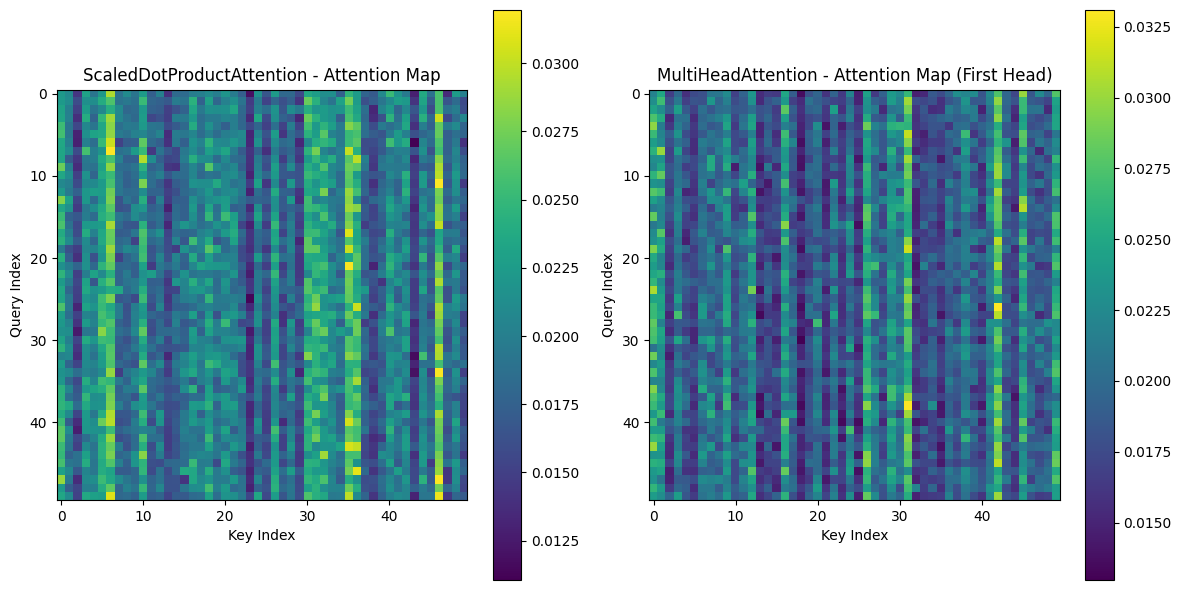

In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense
import numpy as np
import matplotlib.pyplot as plt

class ScaledDotProductAttention(Layer):
    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()

    def call(self, q, k, v, mask=None):
        matmul_qk = tf.matmul(q, k, transpose_b=True) 
        dk = tf.cast(tf.shape(k)[-1], tf.float32)  
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk) 

        if mask is not None:  # Apply mask if necessary
            scaled_attention_logits += (mask * -1e9)

        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1) 
        output = tf.matmul(attention_weights, v)
        return output, attention_weights
        
class MultiHeadAttention(Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % num_heads == 0 
        self.depth = d_model // num_heads

        self.wq = Dense(d_model)
        self.wk = Dense(d_model)
        self.wv = Dense(d_model)
        self.dense = Dense(d_model) 

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3]) 

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = ScaledDotProductAttention()(q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)

        return output, attention_weights

# Test input for attention layers
q = tf.random.uniform((64, 50, 512))  # Query tensor (batch_size, seq_length, d_model)
k = tf.random.uniform((64, 50, 512))  # Key tensor (batch_size, seq_length, d_model)
v = tf.random.uniform((64, 50, 512))  # Value tensor (batch_size, seq_length, d_model)
mask = None  # No mask

# Calculate attention for ScaledDotProductAttention
attention_output, attention_weights = ScaledDotProductAttention()(q, k, v, mask)

# Calculate attention for MultiHeadAttention
multi_head_attention = MultiHeadAttention(d_model=512, num_heads=8)
output, attn_weights = multi_head_attention(v, k, q, mask)

# Visualize the attention weights for the first sample in the batch (index 0)
attn_weights_2d_sda = attention_weights[0].numpy()  # Attention weights for ScaledDotProductAttention
attn_weights_2d_mha = attn_weights[0][0].numpy()  # Attention weights for MultiHeadAttention (first head)

# Create subplots to show the heatmaps
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Attention Heatmap for ScaledDotProductAttention
im = axs[0].imshow(attn_weights_2d_sda, cmap="viridis")
axs[0].set_title("ScaledDotProductAttention - Attention Map")
axs[0].set_xlabel("Key Index")
axs[0].set_ylabel("Query Index")
fig.colorbar(im, ax=axs[0])

# Attention Heatmap for MultiHeadAttention (first attention head)
im = axs[1].imshow(attn_weights_2d_mha, cmap="viridis")
axs[1].set_title("MultiHeadAttention - Attention Map (First Head)")
axs[1].set_xlabel("Key Index")
axs[1].set_ylabel("Query Index")
fig.colorbar(im, ax=axs[1])

plt.tight_layout()
plt.show()
